In [2]:
import numpy as np
import cPickle
import matplotlib.pyplot as plt
%matplotlib inline


In [29]:
import gzip

class dataset_mnist_small_3d:
    def __init__(self):
          
        f = gzip.open('../mnist_small/mnist_14x14.pkl.gz','rb')
        train_set, valid_set, test_set = cPickle.load(f)
        f.close()

        xs_tr, ys_tr = train_set
        xs_val, ys_val = valid_set
        xs_te, ys_te = test_set
        
        self.xs_tr = xs_tr.reshape(xs_tr.shape[0],1,14,14)
        self.xs_te = xs_te.reshape(xs_te.shape[0],1,14,14)
        self.xs_val = xs_val.reshape(xs_val.shape[0],1,14,14)       

        self.ys_tr =  ys_tr.astype(np.int32)
        self.ys_val = ys_val.astype(np.int32)
        self.ys_te =  ys_te.astype(np.int32)

ds = dataset_mnist_small_3d()
print ds.xs_te.shape

(10000L, 1L, 14L, 14L)


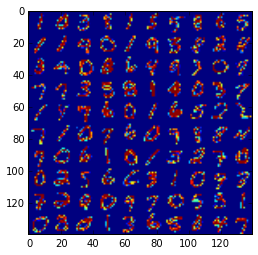

In [67]:
# let's make a bigger image for detection
m = 10;
im = np.zeros((14*m,14*m),dtype='float32')
ind = np.random.choice(10000, m*m)
if 0: # for debug
    print ds.ys_te[ind]
    
for mi in range(m):
    for mj in range(m):
        ij = ind[mi*m + mj]
        im[14*mi:14*(mi+1),14*mj:14*(mj+1)] = ds.xs_te[ij]

plt.imshow(im)  
plt.show()

# let's train a cnn 

In [3]:
import sys 
sys.path.append('../../') 
from layer_for_theano import *
from sgd_for_theano import *
class cnn_small(tt_sgd_model):
    def __init__(self):
        #784
        #dim = 196
        nc = 10

        self.layers = []
        self.layers += [Input2DLayer(500, 1, 14, 14)]

        nonlinearfunc = T.tanh #T.nnet.sigmoid #rectify #rectify
        print 'nonlinear activation function = ', nonlinearfunc
        
        self.layers += [Conv2DLayer(self.layers[-1], filter_shape=[20,1,3,3], activation=nonlinearfunc)]
        self.layers += [Conv2DLayer(self.layers[-1], filter_shape=[50,20,3,3], activation=nonlinearfunc)]
        self.layers += [FlattenLayer(self.layers[-1])]
        # remove hidden layer so it is easier to visualize detection
        #self.layers += [HiddenLayer(self.layers[-1], n_out = 900, activation=nonlinearfunc)]
        self.layers += [HiddenLayer(self.layers[-1], n_out = 10)]
        
        self.layers +=  [ SoftmaxLayer(self.layers[-1])]

        target = T.ivector('target')
        output_eval = self.layers[-1].output()
        self.cost_eval = mcloss_negli(output_eval, target)
        self.err_eval = mc_error(output_eval, target)
        self.validate_model = theano.function([self.layers[0].input, target], self.err_eval)
        self.cost_model = theano.function([self.layers[0].input, target], self.cost_eval)

        output_tr = self.layers[-1].output(dropout_training=True)
        self.cost_tr = mcloss_negli(output_eval, target)
        
        all_para = self.get_all_parameters()
        #learning_rate = 0.13
        #updates = gen_updates_sgd(self.cost_tr, all_para, learning_rate)
        learning_rate = 0.01
        updates = get_update_rmsprop(self.cost_tr, all_para, learning_rate)        
        self.train_model = theano.function([self.layers[0].input, target], self.cost_tr, updates=updates)

model = cnn_small()
if 0:
    best_err, best_model,err_list_val, err_list_tr =  sgd_batch(model, ds.xs_tr, ds.ys_tr, ds.xs_te, ds.ys_te, batch_size=600, n_epochs=2)
    best_model.save_params('cnn_model.param')

nonlinear activation function =  Elemwise{tanh,no_inplace}


In [5]:
best_model = cnn_small()
best_model.load_params('cnn_model.param')
print best_model.get_layers_desc()

nonlinear activation function =  Elemwise{tanh,no_inplace}
inputIm(,1x14x14) 
Conv2D_Elemwise{tanh,no_inplace}(,20x12x12) 
Conv2D_Elemwise{tanh,no_inplace}(,50x10x10) 
FlattenDim=2 
Hidden_Elemwise{tanh,no_inplace}(5000x10) 
SoftmaxLayer` 



In [18]:
for ii in range(len(best_model.layers)):
    params_i = best_model.layers[ii].get_params_values()
    print '== layer ', ii
    for pi in params_i:
        print pi.shape

== layer  0
== layer  1
(20L, 1L, 3L, 3L)
(20L,)
== layer  2
(50L, 20L, 3L, 3L)
(50L,)
== layer  3
== layer  4
(5000L, 10L)
(10L,)
== layer  5


# Let's apply best model for detection

In [32]:
class cnn_small_for_detection(tt_sgd_model):
    def __init__(self):
        #784
        #dim = 196
        nc = 10

        self.layers = []
        #self.layers += [Input2DLayer(500, 1, 14, 14)]
        self.layers += [Input2DLayer(500, 1, 14*4, 14*4)]

        nonlinearfunc = T.tanh 
        
        self.layers += [Conv2DLayer(self.layers[-1], filter_shape=[20,1,3,3], activation=nonlinearfunc)]
        self.layers += [Conv2DLayer(self.layers[-1], filter_shape=[50,20,3,3], activation=nonlinearfunc)]
        
        self.layers += [Conv2DLayer(self.layers[-1], filter_shape=[10,50,10,10]) ]
        
        self.esti = self.layers[-1].output()

model2 = cnn_small_for_detection()
print model2.get_layers_desc()

inputIm(,1x140x140) 
Conv2D_Elemwise{tanh,no_inplace}(,20x138x138) 
Conv2D_Elemwise{tanh,no_inplace}(,50x136x136) 
Conv2D_Elemwise{tanh,no_inplace}(,10x127x127) 



In [33]:
for ii in range(len(model2.layers)):
    params_i = model2.layers[ii].get_params_values()
    print '== layer ', ii
    for pi in params_i:
        print pi.shape

== layer  0
== layer  1
(20L, 1L, 3L, 3L)
(20L,)
== layer  2
(50L, 20L, 3L, 3L)
(50L,)
== layer  3
(10L, 50L, 10L, 10L)
(10L,)


In [34]:
# copy the conv filter
model2.layers[1].set_params_values(best_model.layers[1].get_params_values())
model2.layers[2].set_params_values(best_model.layers[2].get_params_values())
model2.layers[3].params[1].set_value(best_model.layers[4].params[1].get_value())


In [57]:
# change the fully connected layer into conv layer
# something may be wrong here!!! The order of numpy array dimensions
ws = best_model.layers[4].params[0].get_value() # (5000, 10)

ws_new = np.zeros((10,50,10,10), dtype=np.float32)
for f in range(10):
    wf = ws[:,f]
    ws_new[f] = wf.reshape(50,10,10)
model2.layers[3].params[0].set_value(ws_new)
print ws_new.shape

(10L, 50L, 10L, 10L)


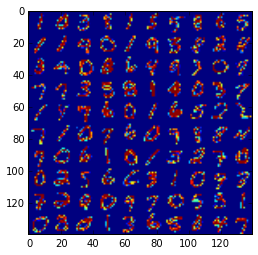

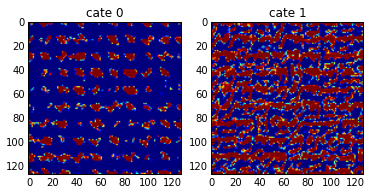

In [76]:
output = model2.esti.eval({model2.layers[0].input: im[np.newaxis, np.newaxis,:] })

filter_im = output[0]

plt.imshow(im)
plt.show()
for c in [0,1]:
    plt.subplot(1,2,c+1)
    plt.imshow( filter_im[c])
    plt.title('cate '+str(c))
plt.show()   

if 0:
    for c in range(10):
        print c, ':', filter_im[0, c].min(), filter_im[0, c].max()